In [270]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import cx_Oracle
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [271]:
NBIN = 10 # số bin đã chia
shapex = 5 # số tháng lịch sử
shapey = 3 # số tháng tương lai

targets = [
    [[9,10],'20%'],
    [[8,9,10],'30%'],
]
cmap = palette=sns.color_palette("RdBu_r",NBIN)

In [272]:
if os.path.exists('data_q.csv'):
    df = pd.read_csv('data_q.csv')
else:
    con = cx_Oracle.connect(user='common',password='Nwpass_Rkcol_0819',
                                    dsn='dwproddc',encoding = 'utf-8',
                                    nencoding = 'utf-8')
    sql = """select a.month, a.unit_code, a.collected_rate, a.full_paid_case
            from HH_CHECK_QUINTILE_10 a"""
    df = pd.read_sql(sql, con)
    df.to_csv('data_q.csv', index=None)
df.head()

,MONTH,UNIT_CODE,COLLECTED_RATE,FULL_PAID_CASE
0,2019/05,FC4260,0.188606,0.450000
1,2019/05,FC4130,0.246353,0.375000
2,2019/05,FC4129,0.198967,0.421429
3,2019/05,FC4173,0.187846,0.415493
4,2019/05,FC4050,0.270057,0.321678


In [273]:
df_info = pd.read_excel('hr_raw.xlsx', sheet_name='Details')
df_info = df_info[['Mã Finone\n(Code bán hàng)', 'Loại nhân viên', 
                   'Khu vực','Trình độ chuyên môn',
                   'Ngày vào làm việc FC']]
df_info.columns = ['UNIT_CODE', 'staff_type', 'region', 'education', 'work_date']
df_info.head()

df = df.merge(df_info, how='left',left_on='UNIT_CODE', right_on='UNIT_CODE')
df.head()
df.work_date = pd.to_datetime(df.work_date, format='%Y=%m-%d')
df['work_months'] = round((pd.to_datetime(df.MONTH, format='%Y/%m') - 
                           pd.to_datetime(df.work_date, format='%Y=%m-%d')).dt.days/30)

df.loc[df['work_months'] < 0 , 'work_months'] = 0
df.head()

df = df[df['UNIT_CODE'].isin(df_info['UNIT_CODE'].to_list())]
df.head()
df = df[df.MONTH != '2020/04']
df.shape

(19363, 9)

In [274]:
# get month frame
def processings_data(fc_code='UNIT_CODE',y_col='RESULT_CHECK', test_month='2019/11'):
    num_month = shapex + shapey
    data = pd.DataFrame()
    for i in range(num_month, len(df.MONTH.unique())+1):
        months = sorted(list(df.MONTH.unique()))[i-num_month:i]
        t0_month = months[shapex-1]
        outmonths = months[-shapey:]
        # select exist 'UNIT_CODE_DESC'
        months_df = [df[df.MONTH == months[i]][fc_code].tolist() for i in range(shapex-1)] 
        for i, x in enumerate(months_df):
            if i == 0:
                fc_list = list(set(x)) 
            else: 
                fc_list = list(set(fc_list) & set(x))
        for i,month in enumerate(months):
            dt_temp = df[df.MONTH == month][[fc_code,y_col]]
            dt_temp.set_index(fc_code, inplace=True)
            col_name = f'QUINTILE_{i}'
            dt_temp.columns = [month]
            if i == 0:
                df_temp = dt_temp
            else:
                df_temp = pd.concat([df_temp, dt_temp], axis=1, sort=True)      
        
        df_temp.dropna(subset=months[:shapex], inplace=True)
        df_temp.fillna(0, inplace=True)
        df_temp['outcome'] = df_temp.loc[:, outmonths].mean(axis=1)
        df_temp = df_temp[df_temp['outcome']!=0]
        #df_temp.dropna( inplace=True)
        df_temp.drop(outmonths, axis=1, inplace=True)
        df_temp.columns = [f't-{i}' for i in range(shapex-1, -1, -1)]+['outcome']
        
        df_infotemp = df[df.MONTH == t0_month][[fc_code,'work_months']]                                               
        df_temp = df_temp.merge(df_infotemp, how='left',left_on=df_temp.index, right_on='UNIT_CODE')
        df_temp.drop(['UNIT_CODE'], axis=1, inplace=True)
        
        cuts = pd.qcut(df_temp['outcome'], q=NBIN, precision=5).unique()
        for j,cut in enumerate(cuts.categories):
            df_temp.loc[(df_temp['outcome'] > cut.left) &(df_temp['outcome'] <= cut.right),'QUINTILE'] =  j +1
        #print(df_temp['QUINTILE'].value_counts())
        
        if t0_month != test_month:
            data = data.append(df_temp)
        else:
            data_test = df_temp
        #print(df_temp)
    data.reset_index(drop=True, inplace=True)
    data.dropna(inplace=True)
    return data, data_test

data, data_test = processings_data(y_col='FULL_PAID_CASE')
print(data.shape, data_test.shape)
data.head(10)

(10844, 8) (1015, 8)


,t-4,t-3,t-2,t-1,t-0,outcome,work_months,QUINTILE
0,0.267857,0.239316,0.248120,0.271318,0.275229,0.278012,44.0,5.0
1,0.315385,0.235294,0.192308,0.252427,0.291262,0.267806,44.0,5.0
2,0.395349,0.306931,0.339623,0.348214,0.388235,0.351358,44.0,9.0
3,0.225564,0.065217,0.250000,0.100840,0.270000,0.216791,44.0,2.0
4,0.356061,0.328571,0.273256,0.325397,0.315789,0.273105,44.0,5.0
5,0.307087,0.211538,0.233577,0.158730,0.190141,0.211875,44.0,2.0
6,0.253425,0.245902,0.174194,0.153226,0.216667,0.265661,44.0,5.0
7,0.401786,0.391304,0.382114,0.324561,0.281250,0.326008,44.0,8.0
8,0.222222,0.226891,0.214286,0.056911,0.302521,0.195315,44.0,1.0
9,0.250000,0.178947,0.287129,0.260274,0.187135,0.143209,44.0,1.0


In [275]:
data_test.outcome.describe()

count    1015.000000
mean        0.246067
std         0.075411
min         0.002252
25%         0.207659
50%         0.249040
75%         0.293782
max         0.519846
Name: outcome, dtype: float64

Text(0.5, 1, 'Correlation matrix')

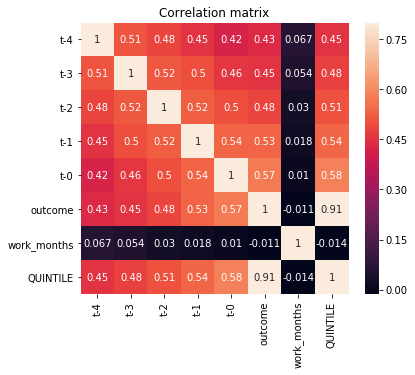

In [276]:
corrmat = data.corr().round(3)
f, ax = plt.subplots(figsize=(6, 5))  
sns.heatmap(corrmat, vmax=.8, annot=True)
plt.title('Correlation matrix')

In [277]:
data.describe()

,t-4,t-3,t-2,t-1,t-0,outcome,work_months,QUINTILE
count,10844.000000,10844.000000,10844.000000,10844.000000,10844.000000,10844.000000,10844.000000,10844.000000
mean,0.274971,0.275330,0.277621,0.278593,0.279244,0.270106,23.236997,5.496404
std,0.083252,0.082173,0.081107,0.079619,0.078982,0.070651,16.074434,2.873984
min,0.008621,0.008621,0.008621,0.008621,0.008621,0.004167,3.000000,1.000000
25%,0.226087,0.226415,0.230769,0.231183,0.231788,0.228011,9.000000,3.000000
50%,0.272727,0.272189,0.274510,0.274809,0.275862,0.266583,18.000000,5.000000
75%,0.323843,0.323186,0.324786,0.325758,0.325997,0.311617,36.000000,8.000000
max,0.635514,0.635514,0.635514,0.727273,0.635514,0.565676,58.000000,10.000000


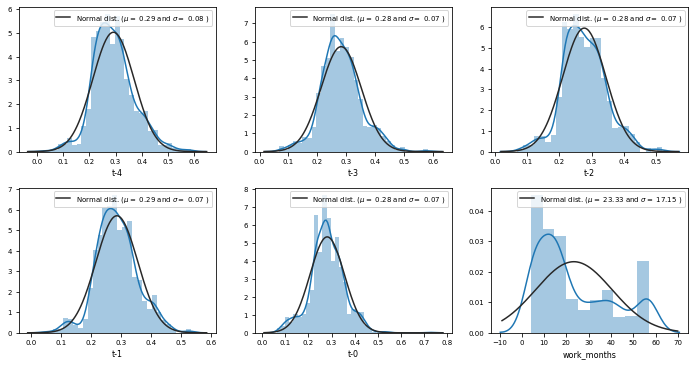

In [278]:
cols = np.array(['t-4','t-3', 't-2', 't-1','t-0','work_months'])
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,6), sharex=False)
fig.subplots_adjust(wspace=0.2, hspace=0.25)
labels = cols.reshape(2, 3)
for r in range(len(axs)):
    for c in range(len(axs[r])):
        sns.distplot(data_test[labels[r,c]],
                    fit=norm,
                    ax = axs[r,c])
        (mu, sigma) = norm.fit(data_test[labels[r,c]])
        
        axs[r,c].set_xlabel(labels[r,c],fontsize=8)
        axs[r,c].tick_params(axis='both', which='major', labelsize=7)
        axs[r,c].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best', fontsize=7)

**Tương quan giữa biến tới outcome**

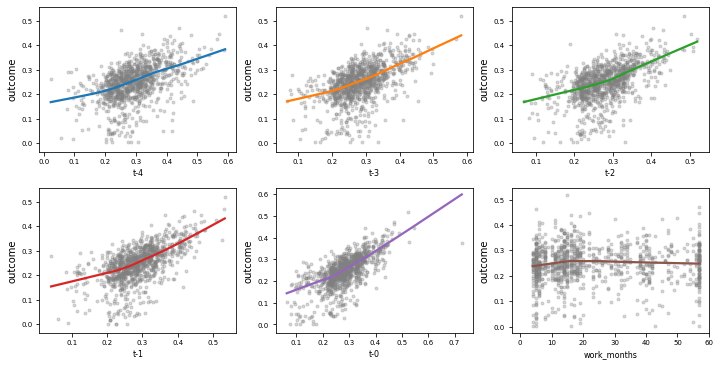

In [279]:
cols = np.array(['t-4','t-3', 't-2', 't-1','t-0','work_months'])
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,6), sharex=False)
fig.subplots_adjust(wspace=0.2, hspace=0.25)
labels = cols.reshape(2, 3)
for r in range(len(axs)):
    for c in range(len(axs[r])):
        sns.regplot(
            x=labels[r,c], 
            y='outcome',
            data=data_test,
            lowess=True,
            marker=".",
            scatter_kws={'alpha':0.3, 'color':'grey'},
            ax=axs[r,c]
        )
        axs[r,c].set_xlabel(labels[r,c],fontsize=8)
        axs[r,c].tick_params(axis='both', which='major', labelsize=7)

In [280]:
from sklearn.model_selection import train_test_split

X = data.drop(['outcome','QUINTILE'],axis=1)
y = data[['outcome','QUINTILE']]

X_test = data_test.drop(['outcome','QUINTILE'],axis=1)
y_test = data_test[['outcome','QUINTILE']]

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# define GridSearchCV
regressions = [
    [GridSearchCV(
        estimator=RandomForestRegressor(n_jobs=-1),param_grid={
            'n_estimators': [200, 500],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [ 8,9,11,12,15,16],
        },scoring='r2', cv=5, n_jobs=-1), 
     "RF"],
    [GridSearchCV(
        estimator=SVR(), param_grid={
            'C': [1e0, 1e1, 1e2],
            'gamma': np.logspace(-2, 2, 5)
        },scoring='r2', cv=3, n_jobs=-1), 
     "SVR"],
    [GridSearchCV(
        estimator=LinearRegression(), param_grid={
            'normalize': [False, True],
        },scoring='r2', cv=5, n_jobs=-1), 
     "LR"],
]
# solver 
results = []
for reg in regressions:
    print(reg[0])
    reg[0].fit(X, y['outcome'])
    results.append((reg[1], reg[0].best_score_, reg[0].best_params_))
results = pd.DataFrame(results, columns=['regression', 'r2', 'best_params']) 
results

In [281]:
import statsmodels.api as sm      
X1 = sm.add_constant(X)
lm = sm.OLS(y['outcome'], X1).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     1404.
Date:                Wed, 22 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:08:14   Log-Likelihood:                 16468.
No. Observations:               10844   AIC:                        -3.292e+04
Df Residuals:                   10837   BIC:                        -3.287e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0681      0.002     28.238      

In [282]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

regr = LinearRegression()

# random forest
#regr =  RandomForestRegressor()
#regr.set_params(max_depth=4)

regr.fit(X, y['outcome'])
print(regr.score(X, y['outcome']))
pred = regr.predict(X_test)
pd.Series(pred).describe()

0.4373240431103541


count    1015.000000
mean        0.274052
std         0.045169
min         0.131630
25%         0.243042
50%         0.271125
75%         0.300622
max         0.460677
dtype: float64

Text(0.5, 1.0, 'Phân phối kết quả thực tế')

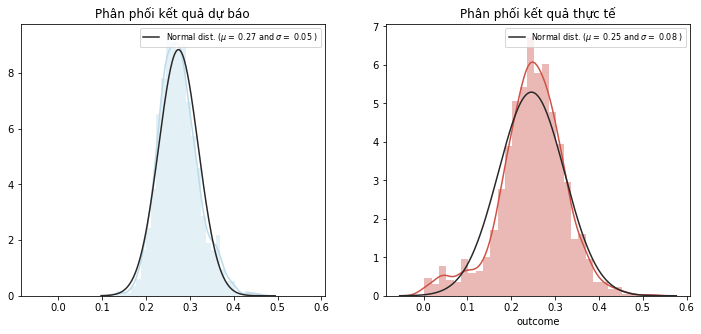

In [283]:
fig, axs = plt.subplots(ncols =2, figsize=(12,5), sharex=True)
#fig.subplots_adjust(wspace=0.2, hspace=0.25)
sns.distplot(pred,
            fit=norm,
            color=cmap[3],           
            ax = axs[0])
(mu, sigma) = norm.fit(pred)
axs[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best', fontsize=8)
axs[0].set_title('Phân phối kết quả dự báo')
sns.distplot(y_test['outcome'],
            fit=norm,
            color=cmap[-2],           
            ax = axs[1])
(mu, sigma) = norm.fit(y_test['outcome'])
axs[1].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best', fontsize=8)
axs[1].set_title('Phân phối kết quả thực tế')

**Bin lại dải xác xuất**

In [284]:
def prob2bin(pred, y_test, NBIN):
    cuts = pd.qcut(pred,NBIN,precision=8).unique()
    df_probs = pd.DataFrame({'score' : pred,
                             'y' : y_test})
    #cuts = pd.qcut(pred, NBIN,precision=5).unique()
    for i,cut in enumerate(cuts.categories):
        left = 0 if i == 0 else cut.left
        right = NBIN if i == NBIN-1 else cut.right
        df_probs.loc[(df_probs.score > left) &(df_probs.score <= right),'bin'] =  i +1 
        df_probs.loc[(df_probs.score > left) &(df_probs.score <= right),'bin_value'] = cut
    df_probs.loc[df_probs.bin >NBIN, 'bin'] = NBIN
    print(df_probs.head(3))
    return df_probs
df_probs = prob2bin(pred, y_test['QUINTILE'], NBIN)

      score    y  bin                 bin_value
0  0.244807  2.0  3.0  (0.23763497, 0.24858507]
1  0.213761  1.0  1.0  (0.13163001, 0.22150011]
2  0.272607  1.0  6.0   (0.27112456, 0.2816992]


**Xác xuất rớt cutoff theo từng chiến lược**

In [285]:
def bin2range(df_probs, targets):
    total = df_probs.groupby('bin').agg(len)['score'] 
    df_range = pd.DataFrame({'total': total})
    for target in targets:
        df_probs[target[1]] = [1 if x in (target[0]) else 0 for x in  df_probs.y.tolist()]
        count_g = df_probs.groupby('bin').sum()[target[1]]/total * 100
        count_g.name = target[1]
        df_range = pd.concat([df_range, count_g], axis=1)
    print(df_range)
    return df_range
df_range = bin2range(df_probs, targets)

      total        20%        30%
bin                              
1.0   102.0   0.000000   0.980392
2.0   101.0   0.000000   2.970297
3.0   102.0   0.000000   0.980392
4.0   101.0   3.960396   7.920792
5.0   101.0   5.940594  18.811881
6.0   102.0  14.705882  26.470588
7.0   101.0  11.881188  26.732673
8.0   102.0  28.431373  47.058824
9.0   101.0  52.475248  75.247525
10.0  102.0  82.352941  93.137255


In [286]:
df_range.sum()/10

total    101.500000
20%       19.974762
30%       30.031062
dtype: float64

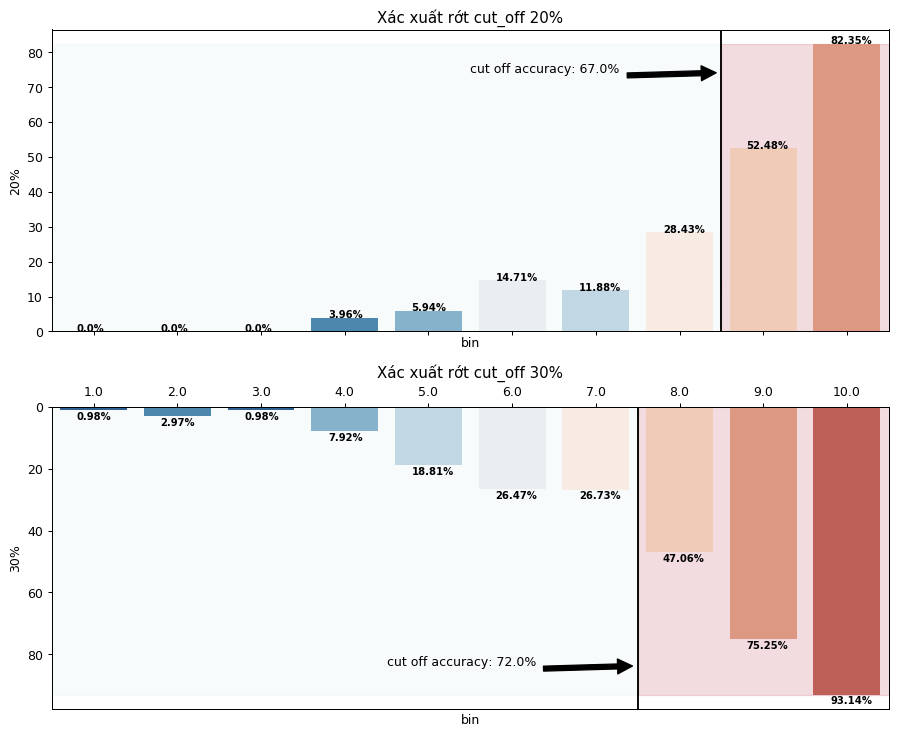

In [287]:
def plot_bin(df_range, targets):
    fig, axs = plt.subplots(nrows = len(targets), figsize = (12,10), dpi=90,sharex=True)
    fig.subplots_adjust(wspace=0.2, hspace=0.25)
    for i, ax, target in zip(range(len(targets)), axs, targets):
        ax.set_xlim(0,max(df_range[target[1]]) + 10)
        sns.barplot(x=df_range.index, y=target[1], data=df_range ,
                palette=cmap,hue=target[1],dodge=False,ax = ax)

        plus = 8 if i%2 == 0 else 1
        for xi,yi in zip(df_range.index-1,df_range[target[1]]):
            ax.text(xi-0.2, yi+3*i,str(round(yi,2))+ '%', fontweight='bold',fontsize = 8)
        ax.legend().remove()
        ax.set_title('Xác xuất rớt cut_off '+ target[1])
        mean = round(df_range.loc[target[0],target[1]].mean(),0)
        ax.annotate( f'cut off accuracy: {mean}%',
                    xy=(min(target[0])-1.5, yi*0.9), 
                    xytext=(min(target[0])-4.5, yi*0.9), 
                    arrowprops=dict(facecolor='black', shrink=0.05)
                   )
        x_range = [0] + list(df_range[target[1]])[1:]
        ax.axvline(x=min(target[0])-1.5, color='k')        
        ax.fill_betweenx(x_range,-1,min(target[0])-1.5, color=cmap[1], alpha=0.03)
        ax.fill_betweenx(x_range,min(target[0])-1.5,NBIN, color=cmap[-1], alpha=0.15)
        #print(min(target[0]))
    if len(targets) == 2:
        axs[1].xaxis.tick_top()
        axs[1].invert_yaxis()
plot_bin(df_range, targets)

In [288]:
def score_PN_rate(df_probs, iter_n=0.1):
    for i in np.arange(0, max(df_probs['score']), iter_n):
        df_probs.loc[(df_probs.score>=i)& (df_probs.score < i+iter_n), 'score_r'] = '%.2f-%.2f'%(i, i+iter_n) 
        #df_probs.loc[(df_probs.score>=i)& (df_probs.score < i+iter_n), 'min'] = i
    dts = []
    for target in targets:
        #print(target)
        x1=df_probs[df_probs.y.isin(target[0])].groupby(['score_r']).agg(len)[['y']]
        x1.columns = [target[1] +'P']
        x0=df_probs[~df_probs.y.isin(target[0])].groupby(['score_r']).agg(len)[['y']]
        x0.columns = [target[1] +'N']
        x = df_probs.groupby(['score_r']).agg(len)[['y']]
        x = x.merge(x1,how='left', on='score_r')
        x = x.merge(x0,how='left', on='score_r')
        #x.columns = ['count', 'P','N']
        x['P'] = x[target[1] +'P']/x['y'] * 100
        x['#'] = x['y'] * 100 / x['y'].sum()   
        x.dropna(subset=['#'], inplace=True)
        x.fillna(0, inplace=True)
        #x.sort_index(ascending=True, inplace=True)
        dts.append(x)
    fig, axs = plt.subplots(ncols=len(targets)+1, figsize=(12,8), sharey=True, dpi=90)
    #x[['P']].plot.barh(ax = axs[1], width=0.2, color=cmap[1], alpha=0.5)
    dts[0][['#']].plot.barh(ax = axs[0], width=0.2, color=cmap[-1], alpha=0.5)
    #print(dts[0])
    #axs[0].invert_xaxis()
    axs[0].scatter(y=x.index, x=x['#'],color=cmap[-1], s=40)
    axs[0].yaxis.tick_right()
    axs[0].tick_params(axis='y',labelsize=7)    
    for yi,xi in enumerate(dts[0]['#'].tolist()):
        axs[0].text(xi, yi+0.2, '%.1f'%(xi) + '%', fontsize=6.5, fontweight='bold')
    # %P
    axs[0].get_legend().remove()  
    axs[0].set_xlabel('%')
    axs[0].set_title('% share')
    for i, ax in enumerate(axs[1:]):
        dts[i][['P']].plot.barh(ax = ax, width=0.2, color=cmap[1+i], alpha=0.7)
        ax.scatter(y=dts[i].index, x=dts[i]['P'],color=cmap[1+i], s=40)
        for yt, xt in enumerate(dts[i]['P'].tolist()):
            ax.text(xt, yt+0.2, '%.1f'%(xt) + '%', fontsize=6)   
        ax.get_legend().remove()       
        ax.set_title(f'xác xuất rớt {targets[i][1]}')

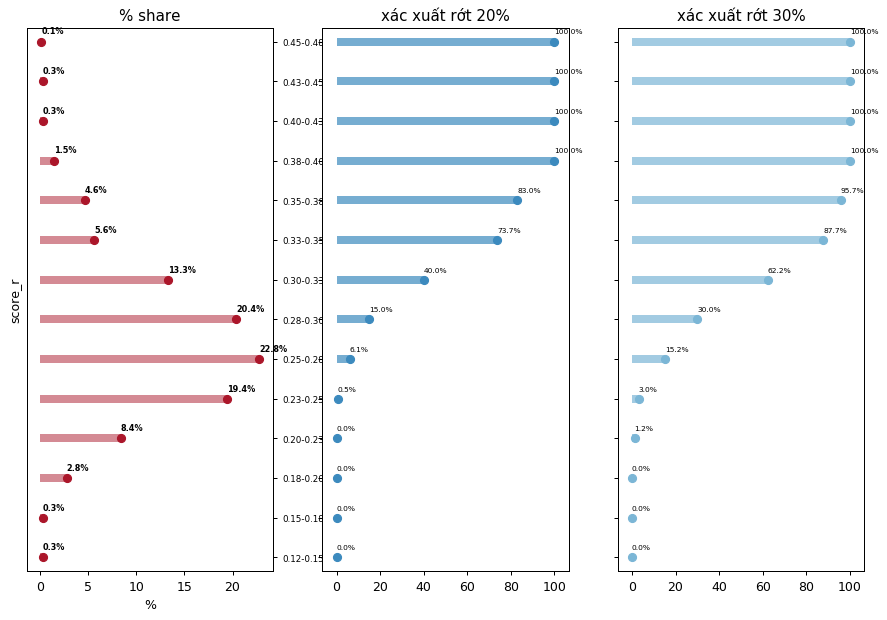

In [289]:
score_PN_rate(df_probs, iter_n=0.025)

X = data.drop(['outcome','QUINTILE'],axis=1).values
y_q = data['QUINTILE']
y = data[['outcome']].values
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X_test = data.drop(['outcome','QUINTILE'],axis=1).values
y_qtest = data['QUINTILE']
y_test = data[['outcome']].values
X_test = np.reshape(X, (X.shape[0], X.shape[1], 1))

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential

# Xay dung model LSTM
warnings.filterwarnings('ignore')

# Xay dung model LSTM
regressor = Sequential()
regressor.add(LSTM(units = 20, return_sequences = True, input_shape = (X.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 20, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 20, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 20))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

#regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
#regressor.compile(loss='mean_squared_error',
regressor.compile(loss='mean_squared_error',
              optimizer='adam',)
regressor.summary()

numOfEpoch = 500
H = regressor.fit(X, y, 
              epochs=numOfEpoch, 
              batch_size=1000, 
              #validation_data=(X_test, y_test), 
              verbose=1)

pred = regressor.predict(X_test)
pred = pred.reshape(pred.shape[0])
y_test = y_test.reshape(y_test.shape[0])

df_probs = prob2bin(pred, y_test, NBIN)
df_probs['y'] = list(y_qtest)#len(df_probs)
df_range = bin2range(df_probs, targets)
plot_bin(df_range, targets)